# 다층 퍼셉트론으로 손글씨 분류하기

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt # 시각화를 위한 맷플롯립
from sklearn.datasets import load_digits
digits = load_digits() # 1,979개의 이미지 데이터 로드
import torch
import torch.nn as nn
from torch import optim

첫번째 샘플을 출력

In [13]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


전체 샘플의 개수 확인

In [14]:
print('전체 샘플의 수 : {}'.format(len(digits.images)))

전체 샘플의 수 : 1797


전체 샘플 중에서 상위 5개의 샘플만 시각화

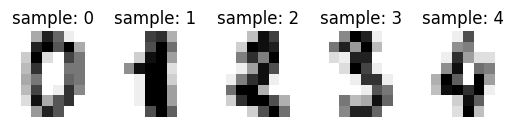

In [15]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

8 × 8 행렬을 전부 64차원의 벡터로 변환해서 저장

In [16]:
X = digits.data # 이미지. 즉, 특성 행렬
Y = digits.target # 각 이미지에 대한 레이블

다층 퍼셉트론 분류기 만들기

In [18]:
model = nn.Sequential(
    nn.Linear(64, 32), # input_layer = 64, hidden_layer1 = 32
    nn.ReLU(),
    nn.Linear(32, 16), # hidden_layer2 = 32, hidden_layer3 = 16
    nn.ReLU(),
    nn.Linear(16, 10) # hidden_layer3 = 16, output_layer = 10
)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.int64)
loss_fn = nn.CrossEntropyLoss() # 이 비용 함수는 소프트맥스 함수를 포함하고 있음.
optimizer = optim.Adam(model.parameters())
losses = []
for epoch in range(100):
  optimizer.zero_grad()
  y_pred = model(X) # forwar 연산
  loss = loss_fn(y_pred, Y)
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, 100, loss.item()
        ))

  losses.append(loss.item())

Epoch    0/100 Cost: 2.412846
Epoch   10/100 Cost: 2.086652
Epoch   20/100 Cost: 1.800046
Epoch   30/100 Cost: 1.477415
Epoch   40/100 Cost: 1.159363
Epoch   50/100 Cost: 0.860276
Epoch   60/100 Cost: 0.603146
Epoch   70/100 Cost: 0.418774
Epoch   80/100 Cost: 0.305362
Epoch   90/100 Cost: 0.234680


시각화

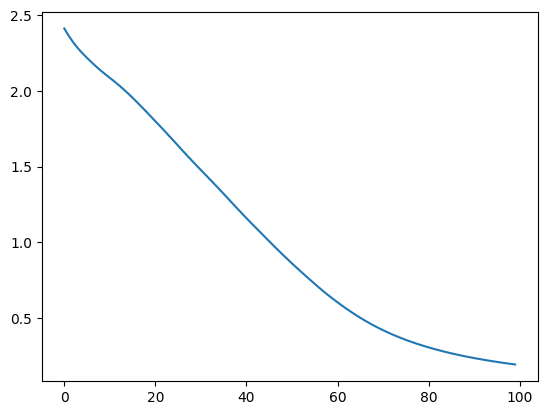

In [19]:
plt.plot(losses)

# CNN으로 MNIST 분류하기

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

학습에 사용할 파라미터를 설정합니다.

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

데이터로더를 사용하여 데이터를 다루기 위해서 데이터셋을 정의해줍니다.

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                          train=True, # True를 지정하면 훈련 데이터로 다운로드
                          transform=transforms.ToTensor(), # 텐서로 변환
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/', # 다운로드 경로 지정
                         train=False, # False를 지정하면 테스트 데이터로 다운로드
                         transform=transforms.ToTensor(), # 텐서로 변환
                         download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 113322988.14it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24044401.31it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 35027635.58it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5183817.35it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



데이터로더를 사용하여 배치 크기를 지정해줍니다.

In [6]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

클래스로 모델을 설계합니다.

In [5]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

CNN 모델 정의

In [7]:
model = CNN().to(device)

비용 함수와 옵티마이저를 정의합니다.

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

총 배치의 수를 출력

In [9]:
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 600


 모델을 훈련시키기

In [10]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.225576848
[Epoch:    2] cost = 0.0623053089
[Epoch:    3] cost = 0.0452254154
[Epoch:    4] cost = 0.0364559703
[Epoch:    5] cost = 0.0302545056
[Epoch:    6] cost = 0.025276145
[Epoch:    7] cost = 0.021307148
[Epoch:    8] cost = 0.0178609658
[Epoch:    9] cost = 0.015989406
[Epoch:   10] cost = 0.0130490977
[Epoch:   11] cost = 0.00997843221
[Epoch:   12] cost = 0.00975158438
[Epoch:   13] cost = 0.00872725993
[Epoch:   14] cost = 0.00641001062
[Epoch:   15] cost = 0.00660606287


테스트를 진행--->98%의 정확도를 얻습니다.

In [11]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9869999885559082
